230513 23:30
submission(14).csv -> 0.02683
cropping, 10 epoch

```
autoencoder = keras.Sequential([
    layers.Input(shape=img_dim),
    # encoder
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    
    layers.Dropout(0.5),

    # decoder
    layers.Conv2DTranspose(128, (3, 3), activation='relu'),
    
    layers.Conv2DTranspose(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    
    layers.Conv2DTranspose(64, (3, 3), activation='relu'),
    layers.Conv2D(1, (1, 1), activation='sigmoid')
])
```

In [1]:
import zipfile
import os
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math

import keras
from keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import Data

### Unzip images into workspace directories

In [2]:
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'

with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
# list of image names
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

crop to 140 (height, 420/3) x 135(width,540/4)

## Preprocess Image

In [3]:
img_dim = (140, 135, 1)

In [4]:
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_np = np.asarray(img, dtype="float32") 
    img_np /= 255.0
    img_np = np.reshape(img_np, img_dim) # expand to 3d
    return img_np

In [5]:
def crop_image(img):
    img_h, img_w = img.shape[0], img.shape[1]
    
    # center image by adding white paddings
    UD_border = img_dim[0] * ((img_h - 1) // img_dim[0] + 1) - img_h
    U, D = UD_border // 2, math.ceil(UD_border / 2)
    
    LR_border = img_dim[1] * ((img_w - 1) // img_dim[1] + 1) - img_w
    L, R = LR_border // 2, math.ceil(LR_border / 2)
    
    padded_img = cv2.copyMakeBorder(img, U, D, L, R, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    
    # crop image
    img_list = []
    no_row, no_col = (img_h + UD_border) // img_dim[0], (img_w + LR_border) // img_dim[1]
    for row in range(no_row):
        for col in range(no_col):
            r1, r2 = row * img_dim[0], (row + 1) * img_dim[0]
            c1, c2 = col * img_dim[1], (col + 1) * img_dim[1]
            crop_img = padded_img[r1:r2, c1:c2]
            img_list.append(crop_img)
    
    return img_list

In [6]:
def load_img(path):
    # load image
    raw_img = cv2.imread(path)
    
    # crop image
    img_list = crop_image(raw_img)
    
    # preprocess - to gray, normalize, to 3d
    processed_list = []
    for img in img_list:
        processed_img = preprocess_image(img)
        processed_list.append(processed_img)
        
    return processed_list

In [7]:
def print_imgs(img_list):
    n = len(img_list)
    for i in range(n):
        plt.subplot(math.ceil(n/4),4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_list[i], cmap='gray')

In [8]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    processed_img = load_img(path + 'train/' + f)
    for img in processed_img:
        train.append(img)

for f in sorted(os.listdir(path + 'train_cleaned/')):
    processed_img = load_img(path + 'train_cleaned/' + f)
    for img in processed_img:
        train_cleaned.append(img)

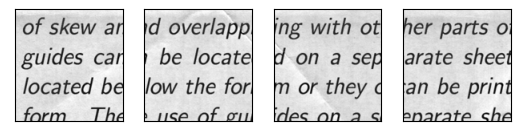

In [9]:
print_imgs(train[4:8])

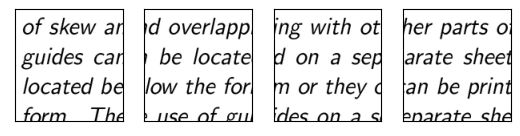

In [10]:
print_imgs(train_cleaned[4:8])

## Train test split
The data size is small, so use a smaller portion of validation set

In [11]:
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [12]:
print(X_train.shape)

(1382, 140, 135, 1)


# Prepare Autoencoder

In [13]:
inputs = Input(shape=img_dim, name='input')

encoder = keras.Sequential([
    Input(shape=img_dim, name='input'),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Reshape((-1, 129 * 128))
#     Permute((3, 1, 2)),
#     Reshape((-1, 134 * 129))
], name='encoder')

In [14]:
print(encoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 138, 133, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 136, 131, 256)     147712    
                                                                 
 batch_normalization (BatchN  (None, 136, 131, 256)    1024      
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 134, 129, 128)     295040    
                                                                 
 dropout (Dropout)           (None, 134, 129, 128)     0         
                                                                 
 reshape (Reshape)           (None, 134, 16512)        0         
                                                           

In [15]:
decoder = keras.Sequential([
    Input(shape=(134, 16512), name='input'),
    Bidirectional(LSTM(129, return_sequences=True)),
    Bidirectional(LSTM(129, return_sequences=True)),
    # reshape the output back to (140, 135)
    Reshape((134, 129, 2)),
    Conv2DTranspose(1, (7, 7)),
    # conv to binary values
    Conv2D(1, (1, 1), activation='sigmoid'),
], name='decoder')

In [16]:
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 134, 258)         17174544  
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 134, 258)         400416    
 nal)                                                            
                                                                 
 reshape_1 (Reshape)         (None, 134, 129, 2)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 140, 135, 1)      99        
 nspose)                                                         
                                                                 
 conv2d_3 (Conv2D)           (None, 140, 135, 1)       2         
                                                           

In [17]:
autoencoder = keras.Model(inputs, decoder(encoder(inputs)), name='vae')

In [18]:
print(autoencoder.summary())

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 140, 135, 1)]     0         
                                                                 
 encoder (Sequential)        (None, 134, 16512)        444416    
                                                                 
 decoder (Sequential)        (None, 140, 135, 1)       17575061  
                                                                 
Total params: 18,019,477
Trainable params: 18,018,965
Non-trainable params: 512
_________________________________________________________________
None


In [19]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae']
                   )

In [20]:
callback = EarlyStopping(monitor='val_loss', 
                         patience=15,
                         restore_best_weights=True)

hist = autoencoder.fit(X_train, y_train,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(X_val, y_val),
                callbacks=[callback],
               )

Epoch 1/5


2023-05-14 11:14:52.005578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape invae/encoder/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 [==============================] - 35s 405ms/step - loss: 0.0749 - mae: 0.1816 - val_loss: 0.0732 - val_mae: 0.1360
Epoch 2/5
44/44 [==============================] - 14s 314ms/step - loss: 0.0597 - mae: 0.1500 - val_loss: 0.0647 - val_mae: 0.1301
Epoch 3/5
44/44 [==============================] - 14s 313ms/step - loss: 0.0543 - mae: 0.1394 - val_loss: 0.0577 - val_mae: 0.1715
Epoch 4/5
44/44 [==============================] - 13s 307ms/step - loss: 0.0498 - mae: 0.1312 - val_loss: 0.0974 - val_mae: 0.2864
Epoch 5/5
44/44 [==============================] - 13s 306ms/step - loss: 0.0454 - mae: 0.1228 - val_loss: 0.1167 - val_mae: 0.3145


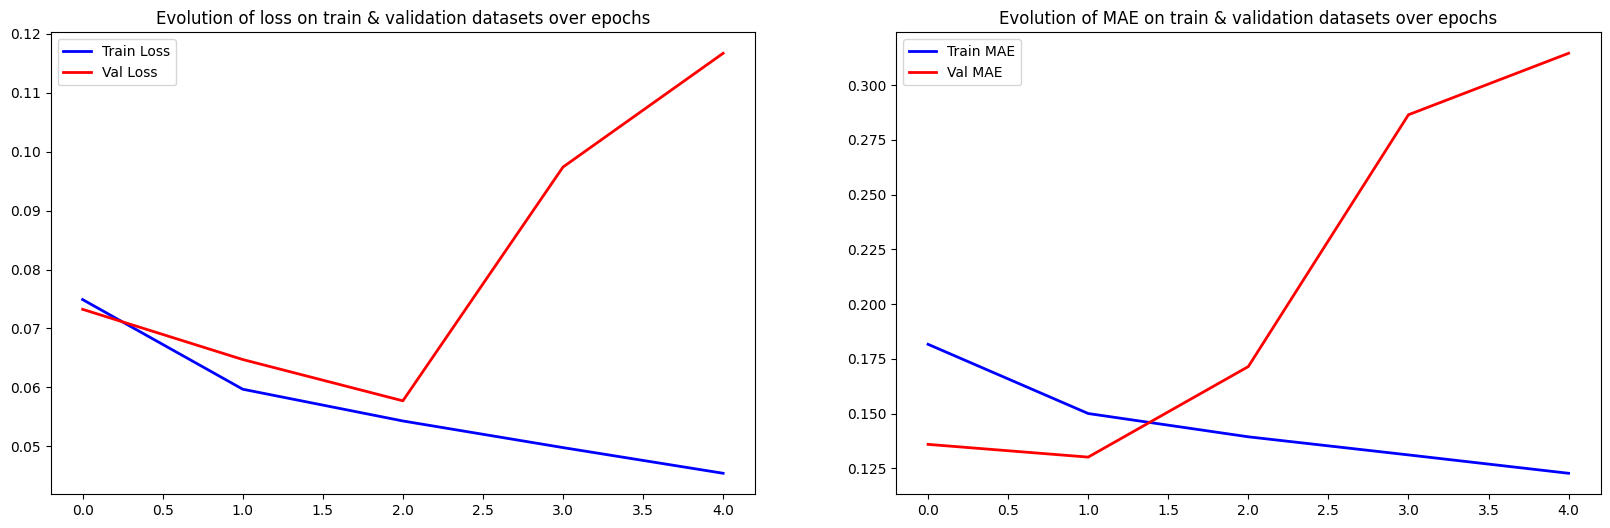

In [21]:
# Check how loss & mae went down
epoch_loss = hist.history['loss']
epoch_val_loss = hist.history['val_loss']
epoch_mae = hist.history['mae']
epoch_val_mae = hist.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

# Inference
note: we need to crop the image -> prediction -> reconstruction

In [22]:
def reconstruct_img(img_list, path):
    # obtain original image and borders dimensions
    img = cv2.imread(path)
    img_h, img_w = img.shape[0], img.shape[1]
    
    UD_border = img_dim[0] * ((img_h - 1) // img_dim[0] + 1) - img_h
    U, D = UD_border // 2, math.ceil(UD_border / 2)
    
    LR_border = img_dim[1] * ((img_w - 1) // img_dim[1] + 1) - img_w
    L, R = LR_border // 2, math.ceil(LR_border / 2)
    
    no_row, no_col = (img_h + UD_border) // img_dim[0], (img_w + LR_border) // img_dim[1]
    
#     print("image size", img.shape)
#     print("paddings", U, D, L, R)
    
    # concatenate the grids back into one image
    # concat by row first
    row_imgs = []
    for row in range(no_row):
        im_r = cv2.hconcat([img_list[row * no_col + col] for col in range(no_col)])
#         print(im_r.shape)
        row_imgs.append(im_r)
        
    # concat all rows to form 1 image
    padded_img = cv2.vconcat(row_imgs)
            
    # remove paddings
    if D > 0 and R > 0:
        crop_img = padded_img[U:-D, L:-R]
    elif D > 0:
        crop_img = padded_img[U:-D]
    elif R > 0:
        crop_img = padded_img[:, L:-R]
    else:
        crop_img = padded_img
        
#     print(padded_img.shape, crop_img.shape)
    return crop_img

In [23]:
y_test = []
c = 0

for f in sorted(os.listdir(path + 'test/')):
    img_path = path + 'test/' + f
    
    # predict
    processed_img = np.asarray(load_img(img_path))
    pred_arr = autoencoder.predict(processed_img, batch_size=16, verbose=0)
    
    # process the output
    pred_list = [pred_arr[i] for i in range(pred_arr.shape[0])]
    processed_output = reconstruct_img(pred_list, img_path)
    y_test.append(processed_output)
    
#     print(processed_output.shape)
#     c += 1
#     if c > 4:
#         break
print(len(y_test))
#     plt.imshow(processed_output, cmap='gray')


72


In [24]:
# it will take a while!
ids = []
vals = []
for i, f in enumerate(test_img):
    file = path + 'test/' + f
    imgid = int(f[:-4])
    img = cv2.imread(file, 0)
    img_shape = img.shape
    # print('Processing image: {} \tinto size: {}'.format(f, img_shape))    # uncomment to see progress
    preds_reshaped = cv2.resize(y_test[i], (img_shape[1], img_shape[0]))

    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

submission = pd.DataFrame({'id': ids, 'value': vals})
submission.to_csv('submission.csv',index = False)

print('Results saved to submission.csv!')
print('Length of IDs: {}'.format(len(ids)))

Results saved to submission.csv!
Length of IDs: 14230080


In [25]:
import shutil
shutil.rmtree(path + 'train/')
shutil.rmtree(path + 'test/')
shutil.rmtree(path + 'train_cleaned/')

In [26]:
df = pd.read_csv("/kaggle/working/submission.csv")